# Computing velocities from positions

If you run this notebook on your own computer (recommended), you need:
* julia (https://julialang.org/downloads/#official_binaries_for_manual_download)
* some julia packages:
    * `PythonPlot` or `PyPlot`
    * `DelimitedFiles` for reading CSV files
    * `DSP` for digital signal processing)
    * `NCDatasets` for loading NetCDF files

* **If** you are using your own computer, you can install these packages with the following julia commands:

```julia
using Pkg
Pkg.add(["PythonPlot", "DelimitedFiles", "DSP", "NCDatasets"])
using PythonPlot, DelimitedFiles, DSP, NCDatasets
```

But the packages need to be installed before the lecture.
Notebook servers

* BlueCloud 2026: https://blue-cloud.d4science.org/, use "Academic/other" sign-in
* https://notebook-gher.uliege.be, **but you need to download your files after each lesson (as they are deleted)**. 


## Exercice

* Compute the drifter velocities from the provided file (drifter number 1).
* Remove the part of the data where the drifter was not deployed or when it was stuck at the coast
* Smooth the data with a second order Butterworth filter (with a cut-off frequency corresponding to a period of 10 minutes) from the `DSP` package (example code is provided below).
* Plot the trajectory and the currents with the coastline and bathymetry (isobath 25 m, 50 m, 75 m, 100 m)
  
Data files:
* Drifter positions: https://dox.ulg.ac.be/index.php/s/A3KkDQYmdNLlabx/download . The data is in the CSV format (comma-separated values) where the columns are the time (in UTC), longitude (degree East) and latitude (degree North).
* Bathymetry: https://dox.ulg.ac.be/index.php/s/9ZwWDbsTgCwgS90/download as a NetCDF file.

You are explicitly encouraged to consult the documentation of these software packages and to use a search engine.

This is the metadata for the deployement from previous students:

```
Timing drifters le 08 mai: 
1: 9h12-14h31 
2: 9h14-14h37 
3: 9h07-14h12 
4: 9:11-14h26 
5: 9h10-14h20 
6: 9h13-14h32 
7: 9h14-14h34 
8: 9h08-14h12 
9: 9h06-14h18 
10: 9h09-14h24
```

The year is 2024 and the times are in local time (UTC-2). The number in the first column is the drifter number.

Additional information:
* The module `DelimitedFiles` allows you to read CSV formatted files with the command `readdlm`. The command `?readdlm` provides for more information. Use for example `readdlm(filename,',');` of the columns a separated by a comma.
* You can convert a string `"2024-05-08T06:20:15"` into a `DateTime` structure (from the module `Dates`) by calling `DateTime("2024-05-08T06:20:15")`
* You can compute the number of seconds between e.g. `"2024-05-08T06:23:34"` and `"2024-05-08T06:20:15"` using:
```julia
using Dates
t0 = DateTime("2024-05-08T06:20:15")
t1 = DateTime("2024-05-08T06:23:34")
time_difference = Dates.value(t1 - t0)/1000 # convert milliseconds to seconds
```
* The function `plot(lon,lat)` from the module `PythonPlot`/`PyPlot` allows you to plot the trajectory given by the longitudes `lon` and latitudes `lat`.

* You can assume that the Earth is a sphere with a radius of 6371009 m. You will need the Earth Radius to convert an increment in degrees to meters.
* The package DSP allow you to apply a 2nd order Butterworth filter. Here is an example using random date `x`. The filtered data is `xf`.

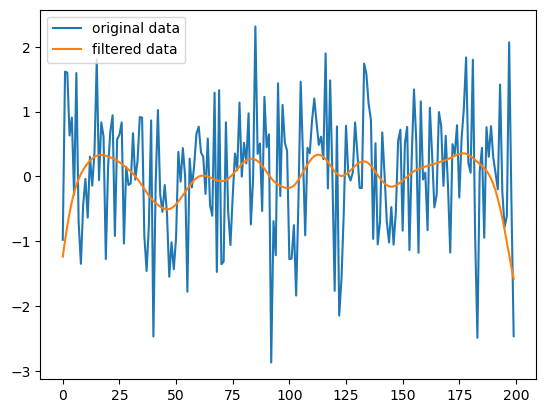

PyObject <matplotlib.legend.Legend object at 0x7fc98bb47ac0>

In [32]:
using DSP
using PyPlot
# Filter parameters
fs = 1/60 # sampling frequency (Hz)
# Cut-off frequency (Hz), 10 minutes
fc = 1/(10*60)

# 2nd order Butterworth filter
bfilter = digitalfilter(Lowpass(fc, fs=fs), Butterworth(2))
x = randn(200);
xf = filtfilt(bfilter, x);
plot(x,label="original data")
plot(xf,label="filtered data")
legend()

* To download and load the bathymetric data you can use the following code snipped:

In [33]:
using NCDatasets
using Downloads: download
bathname = "nwcorsica_bathymetry.nc";

if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/9ZwWDbsTgCwgS90/download",bathname)
end
ds = NCDataset(bathname);
# select only the data within a given bounding box
dss = NCDatasets.@select(ds, 8.7 <= lon <= 8.75 && 42.554 <= lat <= 42.6039)
bat_lon = dss["lon"][:];
bat_lat = dss["lat"][:];
bat = nomissing(dss["bat"][:,:],NaN);

* Here some useful plotting functions:
    * The function `pcolor` (for example `pcolor(bat_lon,bat_lat,bat');`) can be used to visualize the bathymetry
    * The function `contour` (for example `contour(bat_lon,bat_lat,-bat',levels = [0],colors="k",linewidths=2)`) can be used to draw the coastlines or `contour(bat_lon,bat_lat,-bat',levels = [25, 50, 75, 100],colors="k",linewidths=0.2); ` to draw the isobaths 25 m, 50 m, 75 m and 100 m 
    * The function `quiver` (for example `q = quiver(lonf,latf,uf,vf,color="b");`) can be used to draw vectors. The function `quiverkey` adds a legend for quiver (for example `quiverkey(q,0.2,0.9,0.1,label = "0.1 m/s")`)


In [34]:
using Dates
using DelimitedFiles
using Statistics
using DSP # DSP version 0.7.9
using Downloads: download

Download an example CSV file:

In [35]:
filename = "Drifter01_08-05-2024.txt"

if !isfile(filename)
    download("https://dox.ulg.ac.be/index.php/s/A3KkDQYmdNLlabx/download",filename)
end

The text file is a comma separated value file (CSV) where the columns are longitude, latitude, time. 

In [36]:
D = readdlm(filename,',');
time = DateTime.(D[:,1]);
lon = Float64.(D[:,2]);
lat = Float64.(D[:,3]);

Make a simple plot with the axis longitude and latitude

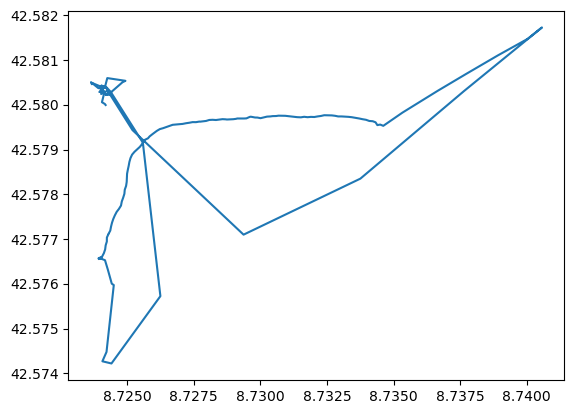

In [37]:
plot(lon,lat);

Plot the data during deployement:

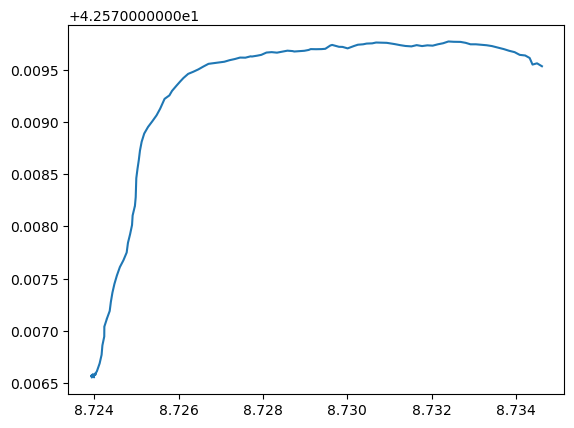

In [38]:
t0 = DateTime(2024,5,8,9,12) - Dates.Hour(2)
t1 = DateTime(2024,5,8,14,31) - Dates.Hour(2)

sel = t0 .<= time .<= t1
plot(lon[sel],lat[sel]);

In [39]:
lon = lon[sel];
lat = lat[sel];
time = time[sel];


Skip also the part where the drifter does not move at the end (because it was stuck at the coast)

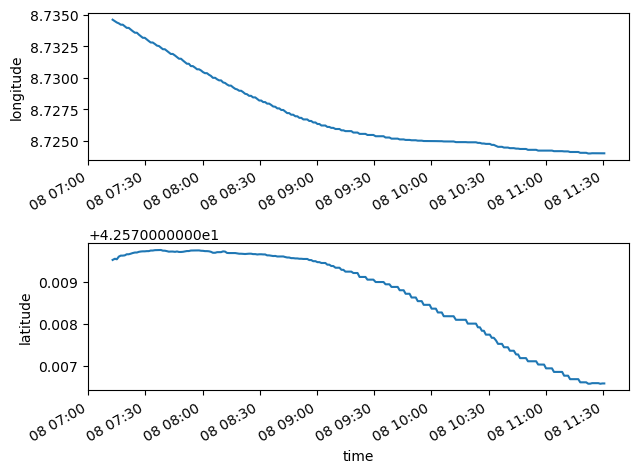

In [40]:
t0 = DateTime(2024,5,8,9,12) - Dates.Hour(2)
t1 = DateTime(2024,5,8,11,31)

sel = t0 .<= time .<= t1

lon = lon[sel];
lat = lat[sel];
time = time[sel];


subplot(2,1,1); 
plot(time,lon)
ylabel("longitude")
setp(gca().get_xticklabels(), rotation=30, horizontalalignment="right");

subplot(2,1,2); 
plot(time,lat)
ylabel("latitude")
xlabel("time")
setp(gca().get_xticklabels(), rotation=30, horizontalalignment="right");
tight_layout();

The convert the position to in a velocity we need to Earth Radius

In [41]:
# Mean radius (http://en.wikipedia.org/wiki/Earth_radius)
R = 6371.009e3;

1 degree in the North-South direction corresponds approximately 111 km.

In [42]:
2*pi*R/360

111195.08372419141

In [43]:
time[1]

2024-05-08T07:12:53

In [44]:
time[2]

2024-05-08T07:14:04

`Dates.value` returns a duration in milliseconds

In [45]:
i=2
Dates.value(time[i+1]-time[i-1])

133000

compute the u (East-West) and v (North-South) velocity component

In [46]:
u = fill(NaN,size(lon))
v = fill(NaN,size(lat))

for i = 2:length(lon)-1
    # convert milliseconds to seconds
    DeltaT = Dates.value(time[i+1]-time[i-1]) / 1000
    v[i] = π*R/180 * (lat[i+1] - lat[i-1]) / DeltaT
    # cosd computes the cosinus of an angle in degree
    u[i] = π*R/180 * (lon[i+1] - lon[i-1]) / DeltaT   * cosd(lat[i])
end



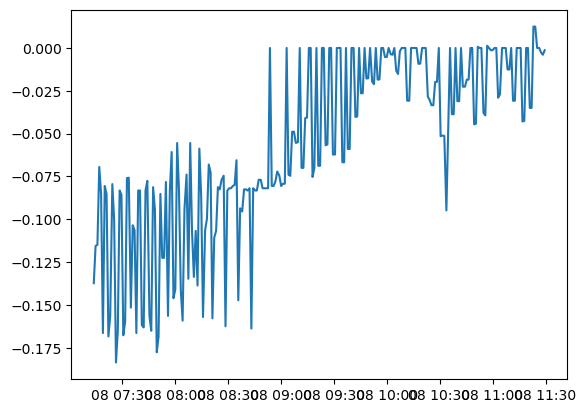

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc9896fac20>

In [47]:
plot(time,u)

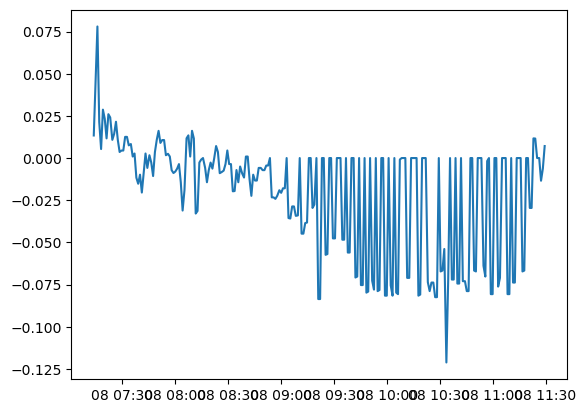

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc989772770>

In [48]:
plot(time,v)

In [49]:
time[1:4]

4-element Vector{DateTime}:
 2024-05-08T07:12:53
 2024-05-08T07:14:04
 2024-05-08T07:15:06
 2024-05-08T07:16:08

Filter the data using the Butterworth filter of order 2 with a cut-off frequency corresponding to 30 minutes

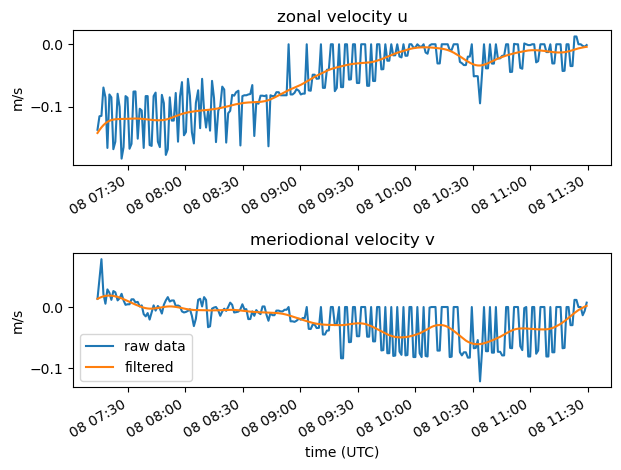

In [50]:
# Filter parameters
fs = 1/60 # sampling frequency (Hz)
# Cut-off frequency (Hz), 30 minutes
fc = 1/(30*60)

# Butterworth filter
bfilter = digitalfilter(Lowpass(fc, fs=fs), Butterworth(2))

uf = filtfilt(bfilter, u[2:end-1])
vf = filtfilt(bfilter, v[2:end-1]);
lonf = lon[2:end-1]
latf = lat[2:end-1]
timef = time[2:end-1]

subplot(2,1,1);
plot(time,u)
plot(timef,uf)
title("zonal velocity u")
ylabel("m/s")
setp(gca().get_xticklabels(), rotation=30, horizontalalignment="right");

subplot(2,1,2);
plot(time,v,label="raw data")
plot(timef,vf,label="filtered")
xlabel("time (UTC)")
ylabel("m/s")
title("meriodional velocity v")
setp(gca().get_xticklabels(), rotation=30, horizontalalignment="right");

legend()
tight_layout()


In [51]:
speedf = sqrt.(uf.^2 + vf.^2);

## Bathymetry

Download the bathymetry as a NetCDF file:

In [52]:
bathname = "nwcorsica_bathymetry.nc";

if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/9ZwWDbsTgCwgS90/download",bathname)
end

Install NCDatasets with if you using julia on your own computer (`NCDatasets` is already installed on the server):

```julia
using Pkg
Pkg.add("NCDatasets")

```

In [53]:
using NCDatasets
ds = NCDataset(bathname);

Load a subset of the NetCDF file

In [54]:
dss = NCDatasets.@select(ds, 8.7 <= lon <= 8.75 && 42.554 <= lat <= 42.6039)

Dataset: nwcorsica_bathymetry.nc
Group: /

Dimensions
   lat = 100
   lon = 100

Variables
  lat   (100)
    Datatype:    Float64
    Dimensions:  lat
    Attributes:
     long_name            = Latitude
     standard_name        = latitude
     units                = degrees_north

  lon   (100)
    Datatype:    Float64
    Dimensions:  lon
    Attributes:
     long_name            = Longitude
     standard_name        = longitude
     modulo               = 360.0
     units                = degrees_east

  bat   (100 × 100)
    Datatype:    Union{Missing, Float32}
    Dimensions:  lon × lat
    Attributes:
     long_name            = elevation above sea level
     standard_name        = height
     units                = meters
     _FillValue           = 1.0
     missing_value        = 1.0



Load the bathymetry and the corresponding longitude and latitude

In [55]:
bat_lon = dss["lon"][:];
bat_lat = dss["lat"][:];
bat = nomissing(dss["bat"][:,:],NaN);

Plot the bathymetry for the Bay of Calvi

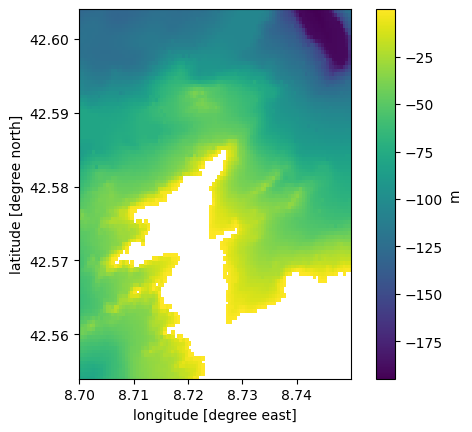

In [56]:
pcolor(bat_lon,bat_lat,bat'); colorbar(orientation="vertical",label="m")
xlabel("longitude [degree east]")
ylabel("latitude [degree north]")
gca().set_aspect(1/cosd(mean(bat_lat)));


Put land values to an positive value so that the coastline corresponds to the contour line of zero.

In [57]:
bat[isnan.(bat)] .= 1 ;

Plot the result with the bathymetry

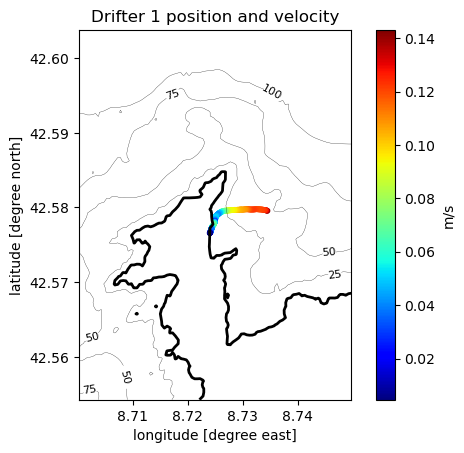

In [58]:
contour(bat_lon,bat_lat,-bat',levels = [0],colors="k",linewidths=2); 
CS = contour(bat_lon,bat_lat,-bat',levels = [25, 50, 75, 100],colors="k",linewidths=0.2); 
gca().clabel(CS, CS.levels, inline=true, fontsize=8)

scatter(lonf,latf,10,speedf,cmap="jet"); colorbar(label="m/s")
xlabel("longitude [degree east]")
ylabel("latitude [degree north]")
title("Drifter 1 position and velocity")
gca().set_aspect(1/cosd(mean(bat_lat)));

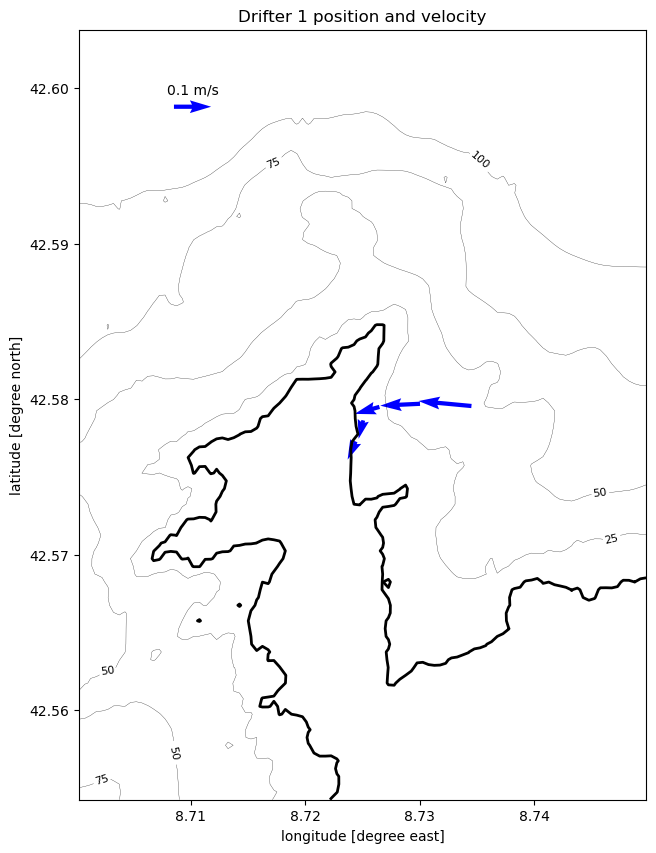

In [59]:
figure(figsize=(10,10))
contour(bat_lon,bat_lat,-bat',levels = [0],colors="k",linewidths=2); 
CS = contour(bat_lon,bat_lat,-bat',levels = [25, 50, 75, 100],colors="k",linewidths=0.2); 
gca().clabel(CS, CS.levels, inline=true, fontsize=8)

s = 1:50:length(lonf)
q = quiver(lonf[s],latf[s],uf[s],vf[s],color="b");
quiverkey(q,0.2,0.9,0.1,label = "0.1 m/s")
xlabel("longitude [degree east]")
ylabel("latitude [degree north]")
title("Drifter 1 position and velocity")
gca().set_aspect(1/cosd(mean(bat_lat)));

Create a NetCDF file with the filtered velocity

In [60]:
ncname = replace(filename,"Drifter" => "drifter",".txt" => ".nc")

"drifter01_08-05-2024.nc"

In [61]:
if isfile(ncname)
    rm(ncname)
end

ds = NCDataset(ncname,"c")

nclon = defVar(ds,"LONGITUDE",lonf,("TIME",))
nclon.attrib["units"] = "degrees_east" ;
nclon.attrib["standard_name"] = "longitude"

nclat = defVar(ds,"LATITUDE",latf,("TIME",))
nclat.attrib["units"] = "degrees_north" ;
nclat.attrib["standard_name"] = "latitude"

# surprisingly CMEMS uses DEPH for depth (not a typo)
ncdepth = defVar(ds,"DEPH",ones(UInt32,size(lonf))'/2,("DEPH","TIME")); 
ncdepth.attrib["units"] = "m" ;
ncdepth.attrib["standard_name"] = "depth"

nctime = defVar(ds,"TIME",timef,("TIME",))
nctime.attrib["standard_name"] = "time"

ncu = defVar(ds,"EWCT",uf',("DEPH","TIME"))
ncu.attrib["units"] = "m/s"
ncu.attrib["standard_name"] = "eastward_sea_water_velocity"

ncv = defVar(ds,"NSCT",vf',("DEPH","TIME"))
ncu.attrib["units"] = "m/s"
ncu.attrib["standard_name"] = "northward_sea_water_velocity"

defVar(ds,"POSITION_QC",ones(UInt32,size(lonf))',("DEPH","TIME"))
defVar(ds,"TIME_QC",ones(UInt32,size(lonf))',("DEPH","TIME"))
defVar(ds,"EWCT_QC",ones(UInt32,size(lonf))',("DEPH","TIME"))
defVar(ds,"NSCT_QC",ones(UInt32,size(lonf))',("DEPH","TIME"))
defVar(ds,"DEPH_QC",ones(UInt32,size(lonf))',("DEPH","TIME"))

display(ds)

close(ds)

Dataset: drifter01_08-05-2024.nc
Group: /

Dimensions
   TIME = 244
   DEPH = 1

Variables
  LONGITUDE   (244)
    Datatype:    Float64 (Float64)
    Dimensions:  TIME
    Attributes:
     units                = degrees_east
     standard_name        = longitude

  LATITUDE   (244)
    Datatype:    Float64 (Float64)
    Dimensions:  TIME
    Attributes:
     units                = degrees_north
     standard_name        = latitude

  DEPH   (1 × 244)
    Datatype:    Float64 (Float64)
    Dimensions:  DEPH × TIME
    Attributes:
     units                = m
     standard_name        = depth

  TIME   (244)
    Datatype:    DateTime (Float64)
    Dimensions:  TIME
    Attributes:
     units                = days since 1900-01-01 00:00:00
     standard_name        = time

  EWCT   (1 × 244)
    Datatype:    Float64 (Float64)
    Dimensions:  DEPH × TIME
    Attributes:
     units                = m/s
     standard_name        = northward_sea_water_velocity

  NSCT   (1 × 244)
    Dataty

closed Dataset